# Import library and API key

In [ ]:
from google.colab import userdata
api_key = userdata.get('sectors_api')

In [11]:
api_key = "dd6ef04c7f7614b5166a60f2af6e921c45f92ce463261651fcb0cc76b491d843"

In [1]:
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
import datetime
import time

import statsmodels.api as sm

# Function

In [2]:
# Create list of date function
def get_date_list(start_date):
    start_date = datetime.datetime.strptime(start_date, '%Y-%m-%d')

    end_date = datetime.datetime.today()

    date_list = []

    while start_date < end_date:
        date_list.append(start_date)
        start_date += timedelta(days=90)

    date_list.append(end_date)

    return date_list

## Correlation Analysis

In [3]:
# Sector's Market Cap data Fetching
def fetch_sectors_market_cap(sector_list):
  # Initiate empty data frame
  df_sec = pd.DataFrame()

  # Iterate through all stock name
  for i in sector_list:
      # Replace the URL with a URL from the Available Endpoints section
      url = f"https://api.sectors.app/v1/sector/report/{i}/?sections=market_cap"

      headers = {
          "Authorization": api_key
      }

      response = requests.get(url, headers = headers)

      if response.status_code == 200:
          data = response.json()
      else:
          # Handle error
          print(response.status_code)

      # Data manipulation
      df_mcap = pd.DataFrame(pd.DataFrame(data).T["quarterly_market_cap"]).T

      df_mcap = pd.json_normalize(df_mcap["market_cap"][0]).T.reset_index()
      df_mcap.columns = ["measurement","value"]
      df_mcap[['measurement', 'year','quarter']] = df_mcap['measurement'].str.split('.', expand=True)
      df_mcap["sector"] = i

      # Combine new fetched data with existing data
      df_sec = pd.concat([df_sec,df_mcap])

  return(df_sec)

In [4]:
# Data Cleansing
def sectors_market_cap_data_cleansing(df_sec):
  #Convert long table to wide table
  df_sec_pivot = df_sec.pivot(index=["measurement","year","quarter"],columns="sector",values="value").reset_index()

  # Remove 'current_ttm_mcap_pavg' from measurement column
  df_sec_pivot = df_sec_pivot[df_sec_pivot.measurement != 'current_ttm_mcap_pavg']

  return(df_sec_pivot)

In [5]:
# Historical plot
def historical_mc_plot(df_sec):
  # Use the same sector data
  df_sec_lags = df_sec.copy()

  # Data Manipulation
  df_sec_lags['date'] = pd.to_datetime(df_sec['year'].astype(str) + '-' + df_sec['quarter'])
  df_sec_lags = df_sec_lags.rename(columns={"value":"mcap"})
  df_sec_lags = df_sec_lags[df_sec_lags.measurement != "current_ttm_mcap_pavg"].sort_values(["sector","year","quarter"])

  # Create the line chart
  plt.figure(figsize=(12, 6))
  for sector in df_sec_lags['sector'].unique():
      plt.plot(df_sec_lags[df_sec_lags['sector'] == sector]['date'],
              df_sec_lags[df_sec_lags['sector'] == sector]['mcap'],
              marker='o',
              label=sector)

  plt.xlabel('Quarter')
  plt.ylabel('Market Cap Value')
  plt.title('Market Cap Value of Sectors Over Quarters and Years')
  plt.legend()
  plt.show()

In [6]:
# Lag Correlation between Sectors
def lag_correlation_sectors(df_sec_cleaned):
  # Create date column using year and quarter column
  df_sec_cleaned['date'] = pd.to_datetime(df_sec_cleaned['year'].astype(str) + '-' + df_sec_cleaned['quarter'])

  # Make a copy dataframe so it will not overwrite the original data
  df_sec_shifted = df_sec_cleaned.copy()

  # Shift data
  for i in ['banks', 'basic-materials','food-beverage', 'oil-gas-coal', 'telecommunication', 'utilities']:
    df_sec_shifted[f'{i}_shifted_2'] = df_sec_shifted[i].shift(2)

  # Calculate correlation
  corr_matrix = df_sec_shifted.drop(['measurement', 'year', 'quarter','date'],axis = 1).corr()
  corr_matrix_filtered = corr_matrix.reset_index()[corr_matrix.reset_index().sector.isin(['banks', 'basic-materials','food-beverage', 'oil-gas-coal', 'telecommunication', 'utilities'])]
  corr_matrix_filtered.set_index("sector",inplace=True)

  # Plot the heatmap
  plt.figure(figsize=(30, 12))
  sns.heatmap(corr_matrix_filtered.drop(['banks', 'basic-materials','food-beverage', 'oil-gas-coal', 'telecommunication', 'utilities'],axis=1), annot=True, cmap=plt.cm.RdBu, vmin=-1, vmax=1)
  plt.title('Correlation Matrix')
  plt.show()

In [7]:
def fetch_top_companies_per_sector(date,stock_list):
  df_daily_hist = pd.DataFrame()

  for i in stock_list:
    for j in range (0,len(date)-1):
        if j==0:
            start_date = date[j]
            start_date = start_date.strftime('%Y-%m-%d')

            end_date = date[j+1]
            end_date = end_date.strftime('%Y-%m-%d')
        else:
            start_date = date[j]+ timedelta(days=1)
            start_date = start_date.strftime('%Y-%m-%d')

            end_date = date[j+1]
            end_date = end_date.strftime('%Y-%m-%d')

        url = f"https://api.sectors.app/v1/daily/{i}/?start={start_date}&end={end_date}"


        headers = {
            "Authorization": api_key
        }

        response = requests.get(url, headers = headers)

        if response.status_code == 200:
            data = response.json()
            df_daily_hist = pd.concat([df_daily_hist,pd.DataFrame(data)])
        
        time.sleep(5)

  return df_daily_hist

In [8]:
def top_companies_data_clean_correlation(df_daily_hist):
  # Date type manipulation
  df_daily_hist["date"] = pd.to_datetime(df_daily_hist["date"])
  df_daily_hist["month"] = df_daily_hist["date"].dt.month
  df_daily_hist["year"] = df_daily_hist["date"].dt.year

  df_daily_hist["close_shift_6_months"] = df_daily_hist.groupby("symbol")["close"].shift(180)

  return(df_daily_hist)

## Seasonality

In [9]:
def get_top_2_companies_per_sectors(sector_list):
  # Initiate empty data frame
  df_top_2_comp = pd.DataFrame()

  # Iterate through all stock name
  for i in sector_list:
      url = f"https://api.sectors.app/v1/sector/report/{i}/?sections=companies"


      headers = {
          "Authorization": api_key
      }

      response = requests.get(url, headers = headers)

      if response.status_code == 200:
          data = response.json()
      else:
          # Handle error
          print(response.status_code)

      # Data Manipulation
      df_company = pd.json_normalize(pd.json_normalize(pd.DataFrame(pd.DataFrame(data).T["top_companies"]).T["companies"][0])["top_mcap"][0])
      df_company['sub_sector'] = i

      # Combine new sector fetched with existing data
      df_top_2_comp = pd.concat([df_top_2_comp,df_company])

  # Take two largest company per sub-sector
  df_top_2_comp = df_top_2_comp.groupby('sub_sector').apply(lambda x: x.nlargest(2, 'market_cap')).drop("sub_sector",axis=1).reset_index().drop("level_1",axis=1)

  return df_top_2_comp

In [10]:
def seasonality_daily_price_cleansing(df_daily_hist):
  # Merge daily data and top companies data to get the subsector for each companies
  df_daily_hist = df_daily_hist.merge(df_top_2_comp[["sub_sector","symbol"]], on = "symbol")

  # Make a new column to combine the symbol and subsector
  df_daily_hist["symbol_sub_sec"] = df_daily_hist["symbol"] + "_" + df_daily_hist["sub_sector"]

  # Create long data to wide data
  df_daily_hist = df_daily_hist.pivot(index=["date"],columns="symbol_sub_sec",values="close").reset_index()

  # Drop columns with null value more than 50% of the data
  df_daily_hist = df_daily_hist.dropna(thresh=df_daily_hist.shape[0]*0.5,axis=1)

  return df_daily_hist

# Sectors Correlation Analysis

## Market Capitalization Correlation

From these 6 sectors, which one do you think have a high correlation between each other and why?

- banks
- basic-materials
- oil-gas-coal
- utilities
- food-beverage
- telecommunication

In [ ]:
# Read data from API
df_sec = fetch_sectors_market_cap(["banks","basic-materials","oil-gas-coal","utilities",'food-beverage','telecommunication'])

In [ ]:
# Read data from file
df_sec = pd.read_csv("/content/sectors_marketcap.csv")

In [ ]:
# Show data
df_sec

,measurement,value,year,quarter,sector
0,prev_ttm_mcap,2.772573e+15,2022,Q2,banks
1,prev_ttm_mcap,3.015205e+15,2022,Q3,banks
2,prev_ttm_mcap,3.042030e+15,2022,Q4,banks
3,prev_ttm_mcap,3.040168e+15,2023,Q1,banks
4,current_ttm_mcap,3.234659e+15,2023,Q2,banks
...,...,...,...,...,...
7,current_ttm_mcap,6.935351e+14,2024,Q1,telecommunication
8,current_ttm_mcap_pavg,2.725116e+14,2023,Q2,telecommunication
9,current_ttm_mcap_pavg,2.987948e+14,2023,Q3,telecommunication
10,current_ttm_mcap_pavg,3.407141e+14,2023,Q4,telecommunication


In [ ]:
# Sectors Market Cap Data Cleansing and Processing
df_sec_cleaned = sectors_market_cap_data_cleansing(df_sec)

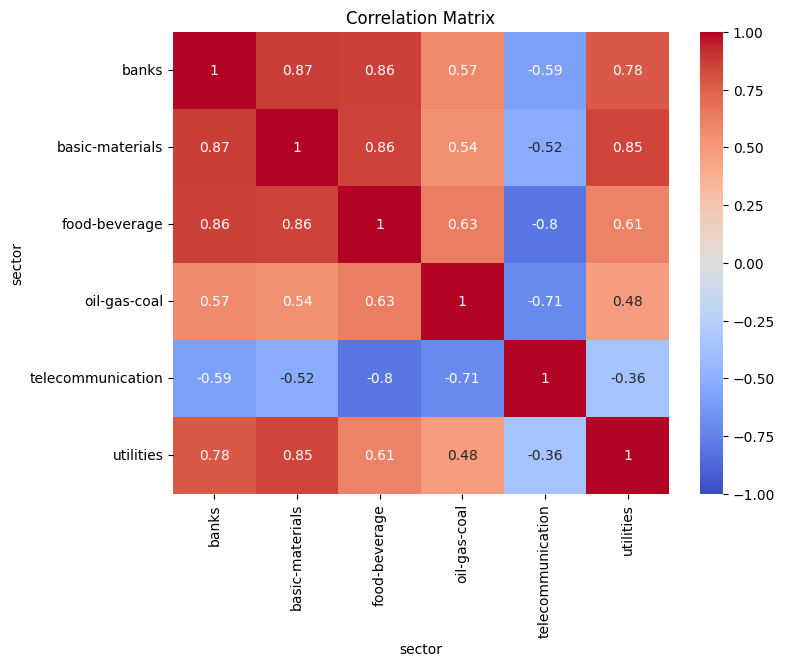

In [ ]:
# Drop some variables and calculate correlation
corr_matrix = df_sec_cleaned.drop(["measurement","year","quarter"],axis = 1).corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Based on the data the, Basic Materials and Banks sectors has the highest correlation, why is this happened?

  *   **Linked Business Activity**: Raw materials are essential for every company to produce their products and might need it in a large scale. While this event explicitly bring benefit for basic materials industry. It is also implicitly bring some opportunities for the bank sector too, for example when company A need to buy basic materials in a large scale they might need to do a financing, and here is when companies in Banks industry come in. Moreover, the higher the material price, it is not only benefitting basic-materials industry, but also banks industry since they will get a higher interest income

  *  **Corporate Synergies**: Many company group in Indonesia has a diversified business line and one of the most usual things is a company in banks and basic-materials industry. Let's take example from Sinarmas group, they have INKP.JK and BSIM.JK. Another example is from Salim group who has INDF.JK and BINA.JK. They might have an internal financing and investment strategies that may benefir both industry.



## Lags Correlation

The information above, we can get valuable information that Basic Materials and Bank Sectors have a high positive correlation, which means when market cap in banks industry increased, the Basic Materials Industry also increased.

However, we can't really predict whether Bank or Basic Material sector's market capitalization will be increasing or decreasing in the next 2-3 months.

Therefore, in this sub-section we will try to create a simple prediction using a cross-correlation (lag correlation) method to see is there any correlation between any sectors today market cap and the market cap for any sector six month ago.

### Sectors to Sectors Lag Correlation

<ipython-input-5-3e75178f90f2>:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sec_lags['date'] = pd.to_datetime(df_sec['year'].astype(str) + '-' + df_sec['quarter'])


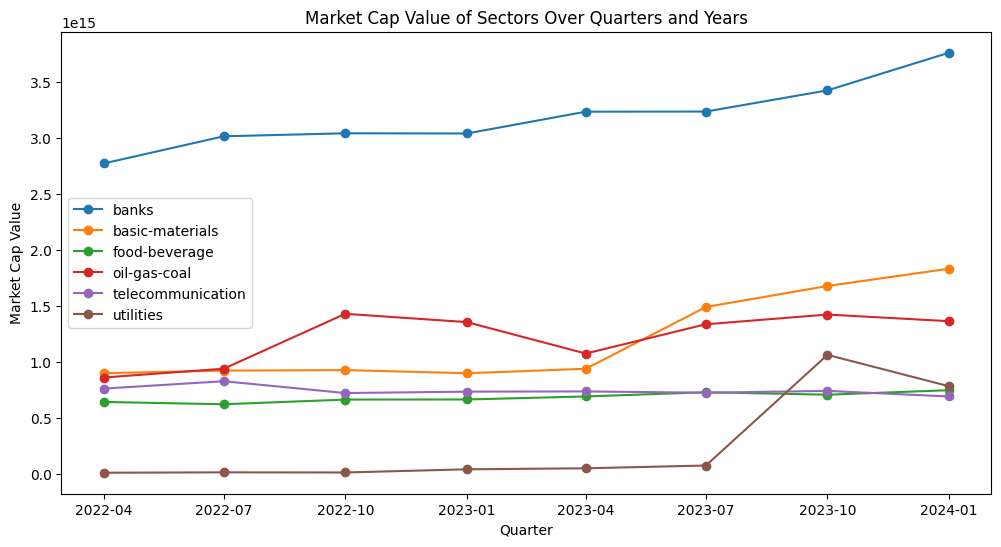

In [ ]:
# Historical Sectors's Market Capitalization Line Plot
historical_mc_plot(df_sec)

<ipython-input-38-33cf16116f62>:4: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_sec_cleaned['date'] = pd.to_datetime(df_sec_cleaned['year'].astype(str) + '-' + df_sec_cleaned['quarter'])


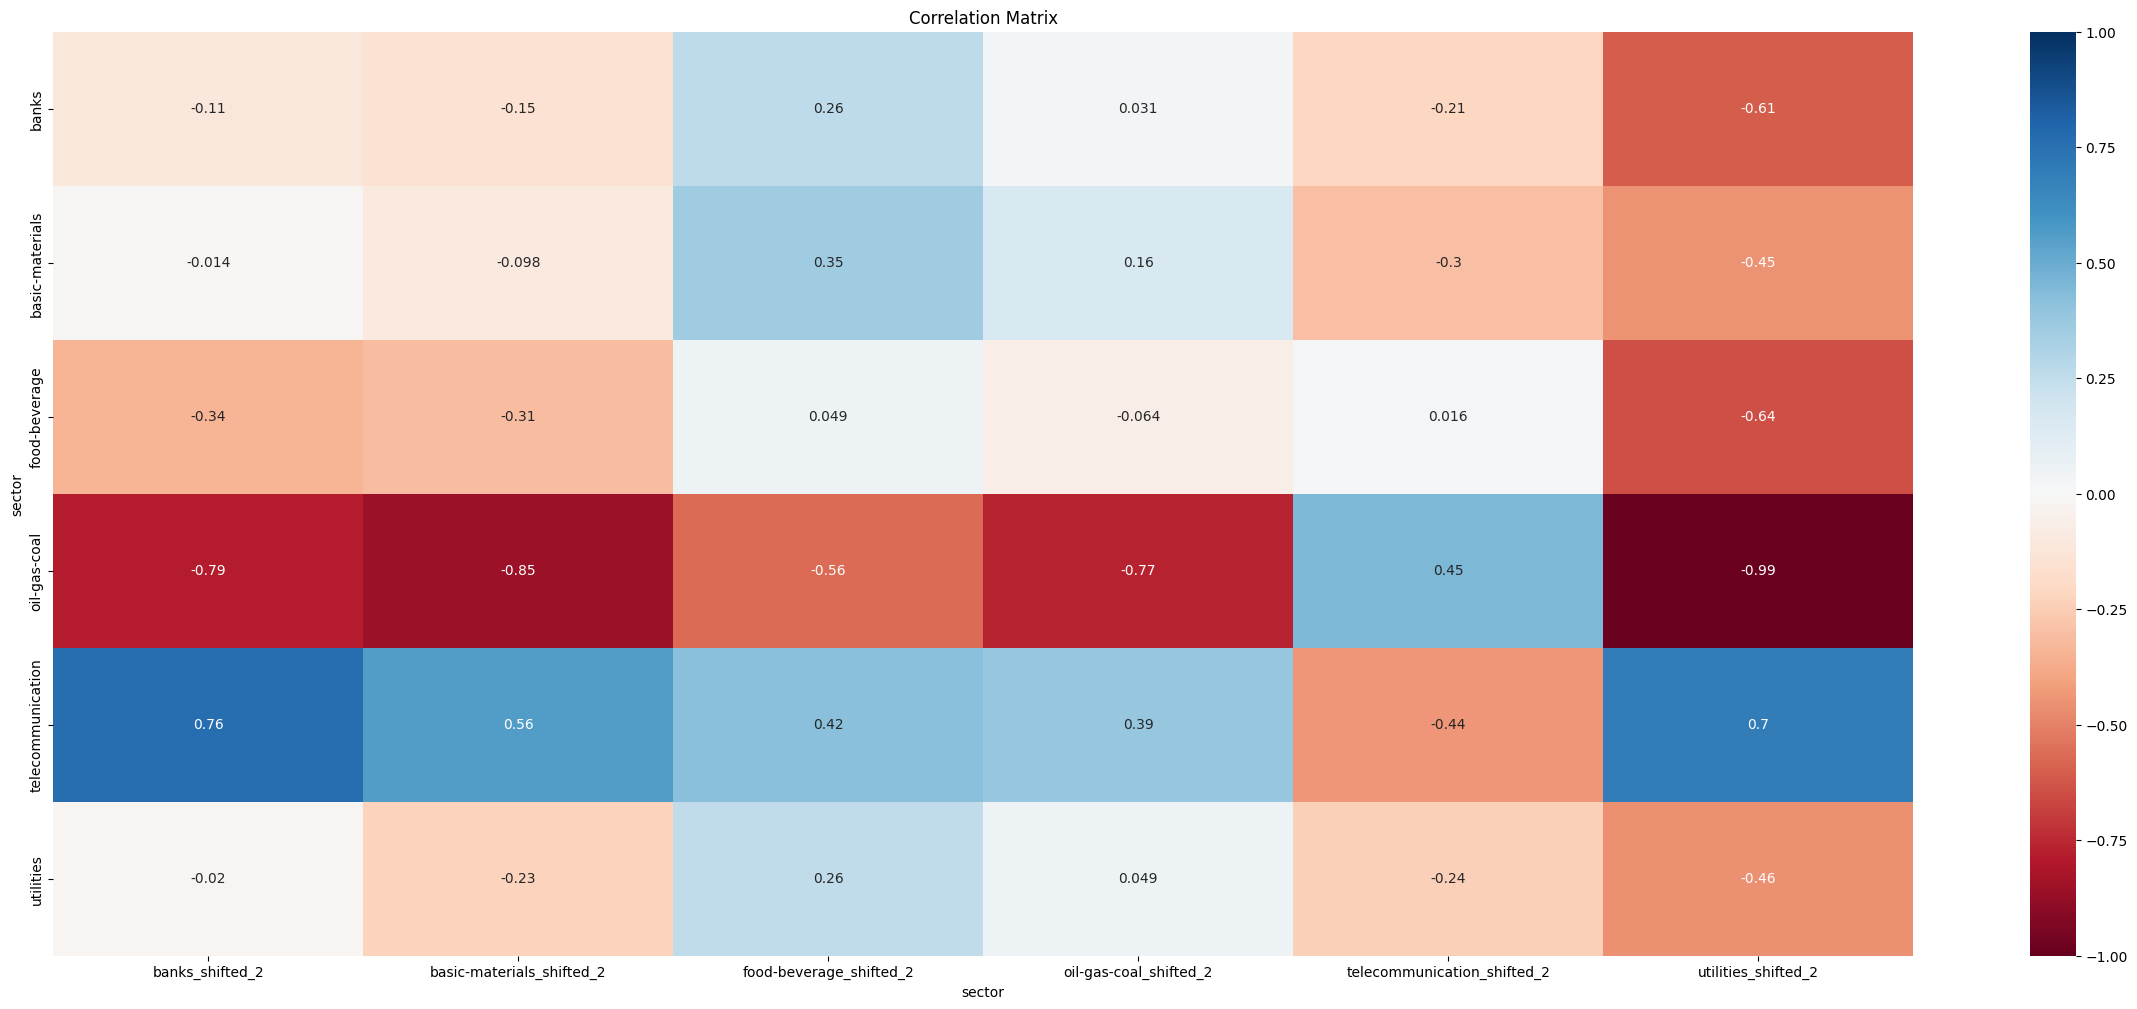

In [ ]:
# Lag Correlation Between Sectors
lag_correlation_sectors(df_sec_cleaned)

Based on the correlation matrix above, we can see that the market cap of utilities sectors 6 months ago have negative correlation with the current oil-gas-coal market cap.

The negative correlation of current oil-gas-coal's industry market cap and the utilities's industry market cap can be caused by several events:


*   Price sensitivity: While utilities industry often have a long-term contract with their suppliers, oil-gas-coal industry rely on the current commodity price, which could reduce the profit of the company.
*   Business Cycle: Oil-gas-coal industry could be identified as seasonal industry where it can have a better performance on certain period of the year, on the other hand utilities is more stable industry. This can also caused the negative correlation between those 2 sectors



### Take Companies From the Highest Correlation Sector

Although we already know that based on the data, oil-gas-coal today market cap has a negative correlation with utilities market cap 6 months ago. However we could also take a deeper analysis by analyzing the correlation between top companies in that two sectors with the exact time frame too.

In [12]:
# Fetch Top Companies Daily data
stock_list = ['BYAN', 'DSSA.JK', 'CUAN.JK', 'ADRO.JK', 'ADMR.JK','PGEO.JK','POWR.JK','KEEN.JK','ARKO.JK']

date = get_date_list("2019-01-01")

df_daily_hist = fetch_top_companies_per_sector(date,stock_list)

/var/folders/93/9kjxv_1n5_17_bh4ztznsxfr0000gn/T/ipykernel_53169/560571209.py:30: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_daily_hist = pd.concat([df_daily_hist,pd.DataFrame(data)])


In [ ]:
# Top Company Correlation Fata Data Cleansing and Processing
df_daily_hist = top_companies_data_clean_correlation(df_daily_hist)

#####2023

In [ ]:
# Calculate Correlation between Companies for year 2023
df_daily_hist_2023 = df_daily_hist[df_daily_hist.year==2023]
df_daily_hist_2023 = df_daily_hist_2023.pivot(index="date",columns="symbol",values=["close","close_shift_6_months"])
df_daily_hist_2023_corr = df_daily_hist_2023.corr().dropna(how='all').dropna(how='all',axis=1)
df_daily_hist_2023_corr.loc[[('close_shift_6_months',"ARKO.JK"),('close_shift_6_months',"POWR.JK"),('close_shift_6_months',"KEEN.JK"),('close_shift_6_months',"PGEO.JK")],[('close',"ADRO.JK"),('close',"BYAN.JK"),('close',"DSSA.JK"),('close',"ADMR.JK"),('close',"CUAN.JK")]]

close                                        
symbol                         ADRO.JK   BYAN.JK   DSSA.JK   ADMR.JK   CUAN.JK
                     symbol                                                   
close_shift_6_months ARKO.JK -0.343947 -0.482829  0.086355 -0.177717 -0.114870
                     POWR.JK  0.007222 -0.248418 -0.450206 -0.015284 -0.463098
                     KEEN.JK -0.690297 -0.647850  0.190228 -0.541679 -0.266970
                     PGEO.JK  0.168060 -0.824866 -0.584835 -0.317658 -0.659650

##### 2024

In [ ]:
# Calculate Correlation between Companies for year 2024
df_daily_hist_2023 = df_daily_hist[df_daily_hist.year==2024]
df_daily_hist_2023 = df_daily_hist_2023.pivot(index="date",columns="symbol",values=["close","close_shift_6_months"])
df_daily_hist_2023_corr = df_daily_hist_2023.corr().dropna(how='all').dropna(how='all',axis=1)
df_daily_hist_2023_corr.loc[[('close_shift_6_months',"ARKO.JK"),('close_shift_6_months',"POWR.JK"),('close_shift_6_months',"KEEN.JK"),('close_shift_6_months',"PGEO.JK")],[('close',"ADRO.JK"),('close',"BYAN.JK"),('close',"DSSA.JK"),('close',"ADMR.JK"),('close',"CUAN.JK")]]

close                                        
symbol                         ADRO.JK   BYAN.JK   DSSA.JK   ADMR.JK   CUAN.JK
                     symbol                                                   
close_shift_6_months ARKO.JK  0.381900 -0.570829  0.590704  0.236184 -0.536916
                     POWR.JK  0.824848 -0.849945  0.501641 -0.278002 -0.503690
                     KEEN.JK  0.594426 -0.663215  0.376958  0.125365 -0.763947
                     PGEO.JK  0.508622 -0.667290  0.750423  0.264566 -0.516704

We can see that BYAN.JK and PGEO.JK has a negative correlations in both year. While the other companies quite have a fluctuative correlation. Based on this analysis, we can say that the current price of BYAN.JK has a negative correlation with the price of PGEO.JK six months ago.

From both correlation matrix we can see that the correlation between sectors cannot be generalized to every companies, since it may has some factors such as:
- time analysis coincidend: The correlation is only happened during the time frame that we used and not occured in another time frame -> which we already overcome using the 2023 and 2024 sampling.
- top companies factor: top companies in each sectors can have a bigger impact to the total market capitalization, which could be a factor whether some sectors correlated with each other or not. For example stock A contribute to 50% of market cap in Utilities sector, changes in A's market cap may effect the correlation between a sectors market cap, although in the reality it is only stock A that correlated with the other sectors.

# Seasonality Analysis

Another noteworthy analysis is the seasonality analysis, it can show how each stock is fluctuated in certain time frame. It can also extract the trend and seasonal components from the stock price.

## Get 2 Top Companies by Market Cap per Sectors

In [ ]:
# Specify what stock to be analyzed
sector_list = ["banks","basic-materials","oil-gas-coal","utilities"]

# Fetch 2 Top 2 Companies in each Sectors
df_top_2_comp = get_top_2_companies_per_sectors(sector_list)

In [ ]:
# Read Data
df_top_2_comp = pd.read_csv("/content/top_2_companies.csv")

In [ ]:
# Show data
df_top_2_comp

,sub_sector,symbol,market_cap
0,banks,BBCA.JK,1140293818646528
1,banks,BBRI.JK,654432891043840
2,basic-materials,AMMN.JK,875657261219840
3,basic-materials,TPIA.JK,793743040970752
4,oil-gas-coal,BYAN.JK,599166057185280
5,oil-gas-coal,DSSA.JK,163357017505792
6,utilities,BREN.JK,1100389881479168
7,utilities,PGEO.JK,49171574816768


## Historical Close Price

In [ ]:
# Fetch historical daily transaction data
date = get_date_list("2019-01-01")

df_daily = fetch_top_companies_per_sector(date,df_top_2_comp.symbol.unique())

In [ ]:
# Read Data
df_daily = pd.read_csv("/content/stocks_daily_data.csv")

In [ ]:
# Seasonality Daily Data Cleansing & Processing
df_daily = seasonality_daily_price_cleansing(df_daily)

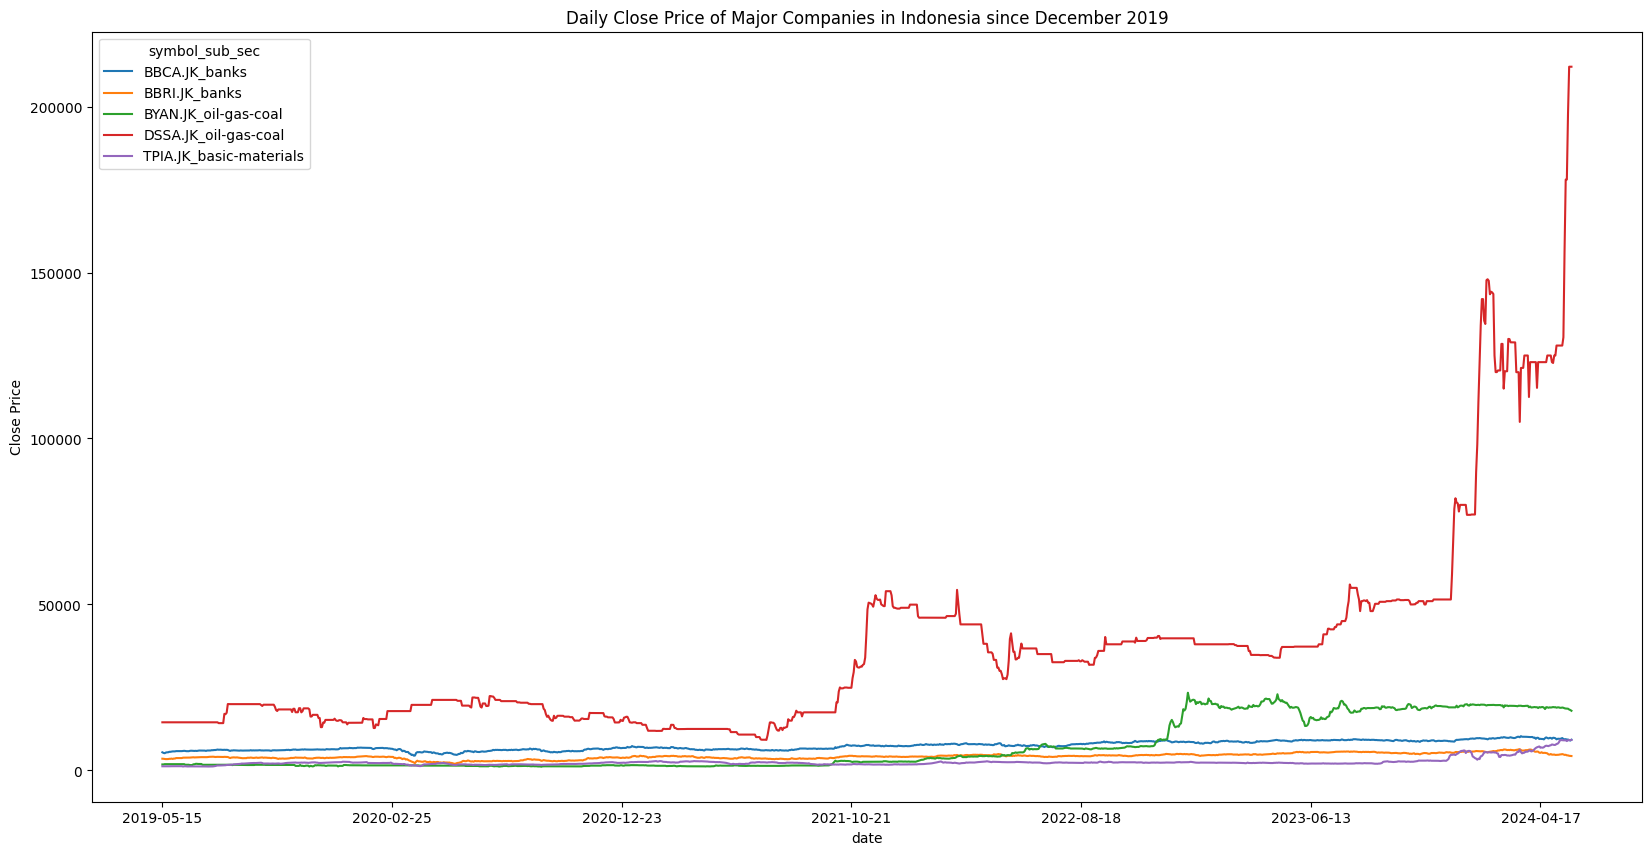

In [ ]:
# Plot Historical Close Price of some Major Companies in Indonesia
df_daily.plot(x="date",figsize=(20, 10), title="Daily Close Price of Major Companies in Indonesia since December 2019")
plt.xlabel("date")
plt.ylabel("Close Price");

## Seasonality Decompose

Every time series data, has 3 components to create a value

y = Trend + Seasonality + Residual (Additive)

y = Trend x Seasonality x Residual (Multiplicative)

In [ ]:
# Datetime data manipulation
df_daily_seas = df_daily.copy()
df_daily_seas["date"] = pd.to_datetime(df_daily_seas["date"])
df_daily_seas = df_daily_seas.set_index("date").asfreq('D')

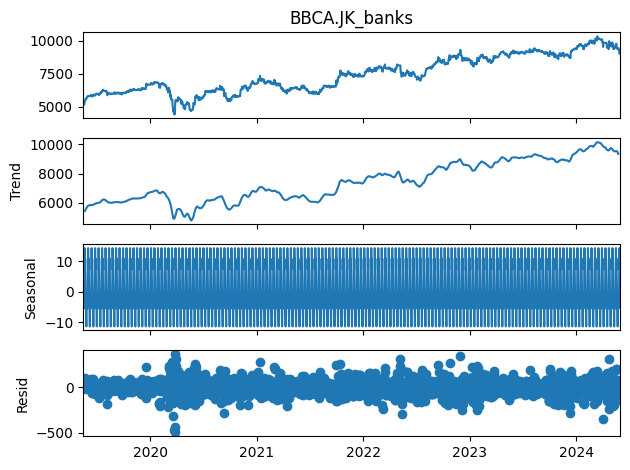

In [ ]:
# Seasonal Decomposition for One Stocks
decomposition = sm.tsa.seasonal_decompose(df_daily_seas["BBCA.JK_banks"].fillna(method="ffill"), model="additive",period=12)
decomposition.plot();

In [ ]:
# Extract Decomposition Value for each Stock
seasonality_dict = {}
trend_dict = {}

for ts in df_daily_seas.columns:
    decompositions = sm.tsa.seasonal_decompose(df_daily_seas[ts].fillna(method='ffill'),period=12)
    # Store the results back
    seasonality_dict[ts] = decompositions.seasonal
    trend_dict[ts] = decompositions.trend

array([[<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>]], dtype=object)

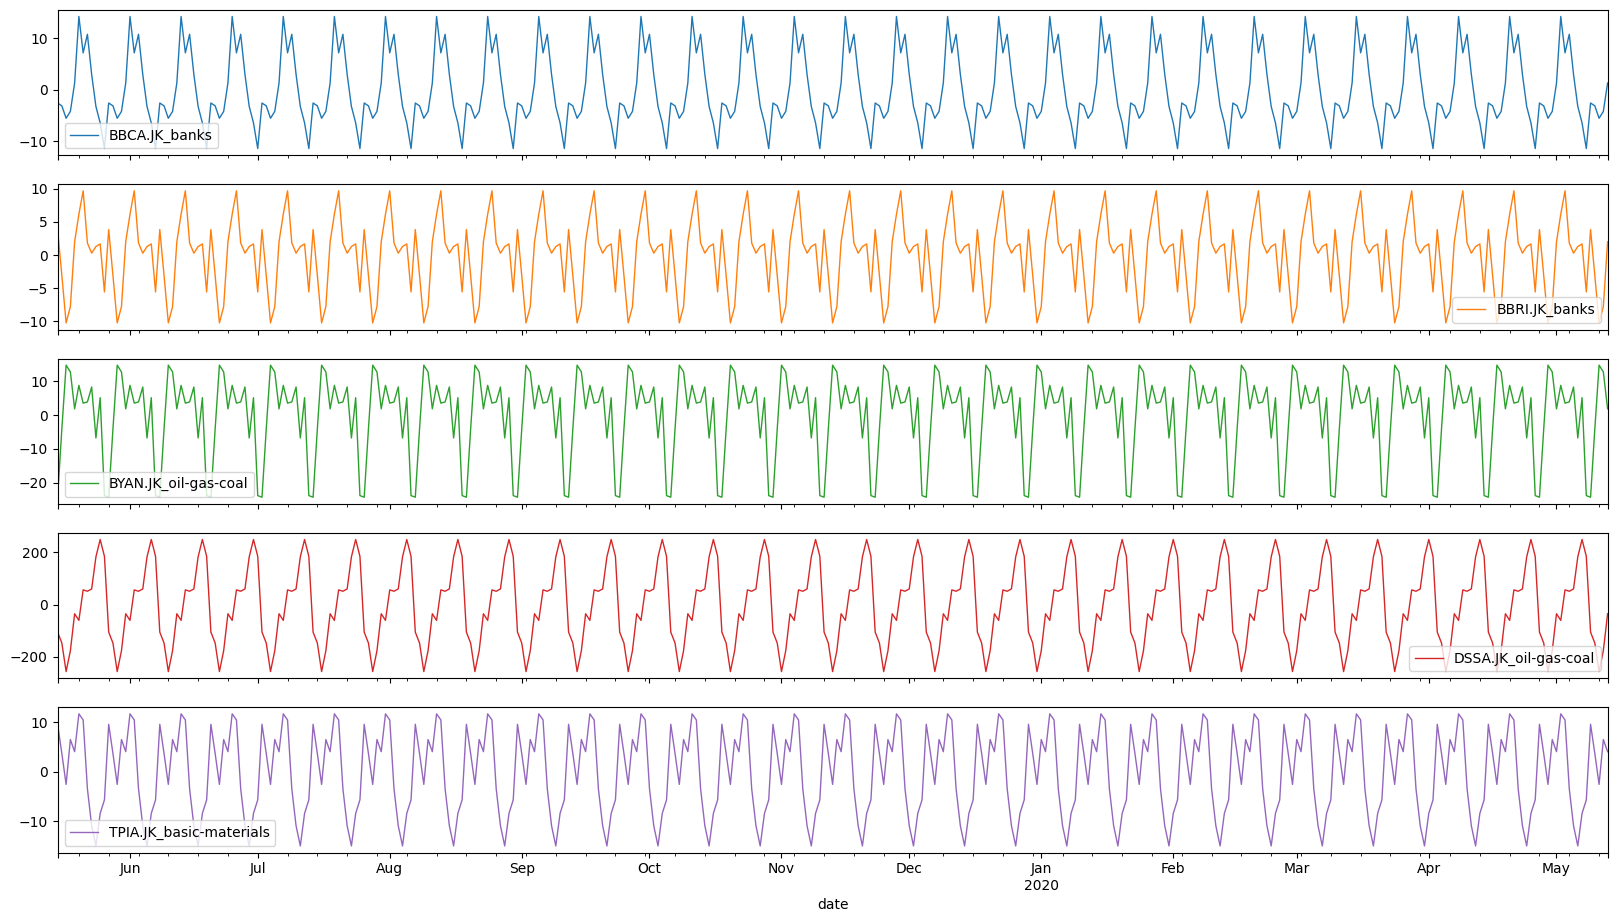

In [ ]:
# Seasonality Plot
pd.DataFrame(seasonality_dict)[0:365].plot(
    subplots=True, layout=(9, 1), linewidth=1, figsize=(20,20)
)

array([[<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>],
       [<Axes: xlabel='date'>]], dtype=object)

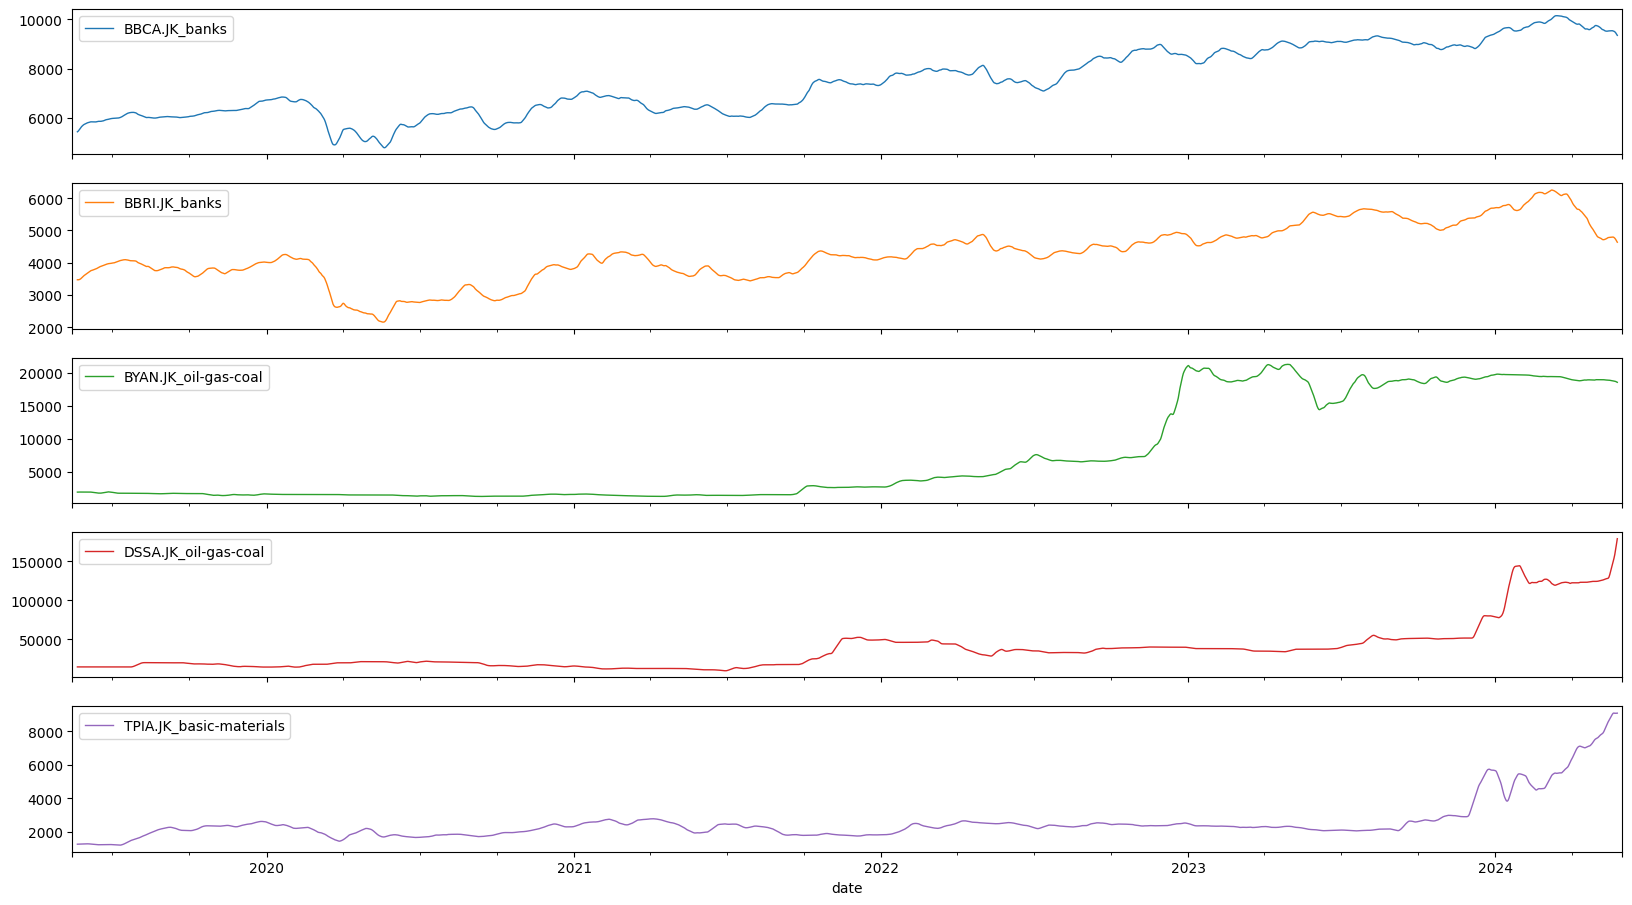

In [ ]:
# Trend Plot
pd.DataFrame(trend_dict).plot(
    subplots=True, layout=(9, 1), linewidth=1, figsize=(20,20)
)